In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from skimage import io
%matplotlib inline

from aux_fun import *

In [2]:
pos_image_fnames = glob.glob('data/vehicles/KITTI_extracted/*.png')
neg_image_fnames = glob.glob('data/non-vehicles/Extras/extra*.png')

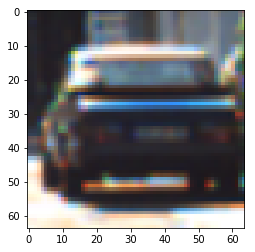

In [3]:
test_pos_img = io.imread(pos_image_fnames[0])
plt.imshow(test_pos_img);

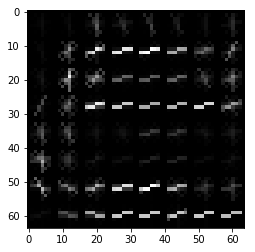

In [4]:
pix_per_cell = 8
cell_per_block = 2
orient = 9

features, hog_image = extract_hog_features(
    cv2.cvtColor(test_pos_img, cv2.COLOR_RGB2LUV)[:,:,0],
    orientations=9, 
    pixels_per_cell=8, 
    cells_per_block=2, 
    vis=True
)

plt.imshow(hog_image, cmap='gray');

In [5]:
def extract_features(img_list):
    feature_list = list()
    for img_fname in img_list:
        img_rgb = io.imread(img_fname)
        #spatial_features = extract_spatial_features(img_rgb)
        #hist_features = extract_hist_features(img_rgb)
        img_luv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LUV)
        hog_features = extract_hog_features(img_luv[:,:,0], 
                                            orientations=9, pixels_per_cell=8, cells_per_block=2)
        #feature_list.append(np.concatenate([spatial_features, hist_features, hog_features]))
        feature_list.append(hog_features)
    return np.vstack(feature_list)

In [6]:
from sklearn.utils import shuffle
def build_dataset(positive_fname_list, negative_fname_list):
    X_0 = extract_features(negative_fname_list)
    y_0 = np.zeros(X_0.shape[0])
    X_1 = extract_features(positive_fname_list)
    y_1 = np.ones(X_1.shape[0])
    return shuffle(np.vstack([X_0, X_1]), np.concatenate([y_0, y_1]))

In [7]:
X, y = build_dataset(pos_image_fnames, neg_image_fnames)

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [9]:
from xgboost import XGBClassifier
clf = XGBClassifier()

In [10]:
from sklearn.model_selection import cross_val_score
score_list = cross_val_score(clf, X_train, y_train, scoring='roc_auc')
print('CV score: %0.3f +- %0.3f' % (np.mean(score_list), 2*np.std(score_list)))

CV score: 0.997 +- 0.001


In [11]:
clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [12]:
from sklearn.metrics import roc_auc_score, accuracy_score
print('Test score - roc_auc: %0.3f' % roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]))
print('Test score - accuracy: %0.3f' % accuracy_score(y_test, clf.predict(X_test)))

Test score - roc_auc: 0.998
Test score - accuracy: 0.981
